# Time series analysis with ARIMA
Some time ago I had a discussion about time series analysis and ARIMA models, which found me quite unprepared!
So I decided to look a bit closer to this neat piece of classical time series analysis. I found out that there are several excellent tutorials on how to use ARIMA, which I link below. Still, I found it useful to compile my own example to summarize my understanding of the problem and to collect links to useful resources.

## Import libraries and get sample data

In [84]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')


Get the classic international airline passengers data, downloadable from the DataMarket webpage (https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) as a CSV with filename "international-airline-passengers.csv".

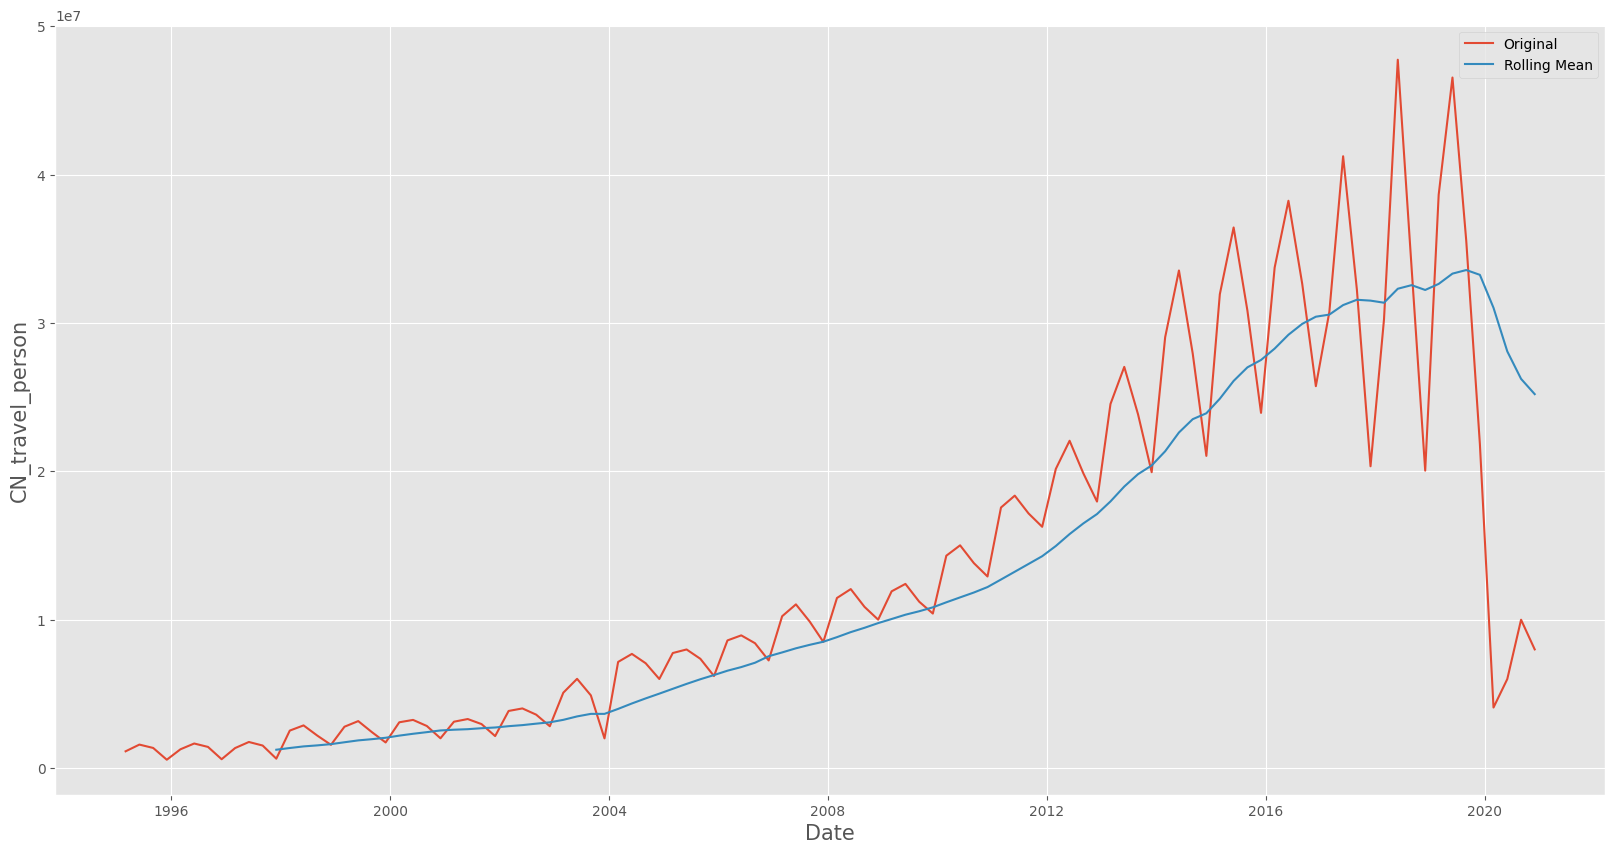

In [85]:
# Load the data
data = pd.read_csv('international-airline-passengers.csv', engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d')
data.set_index(['Month'], inplace=True)

# Plot the data
# 绘制平均值
data_mean = data.rolling(window=12).mean()
# 放在一张图上
plt.figure(figsize=(20,10))
plt.plot(data, label='Original')
plt.plot(data_mean, label='Rolling Mean')
plt.legend(loc='best')

plt.ylabel('CN_travel_person',fontdict={'size':15})
plt.xlabel('Date',fontdict={'size':15})
plt.show()

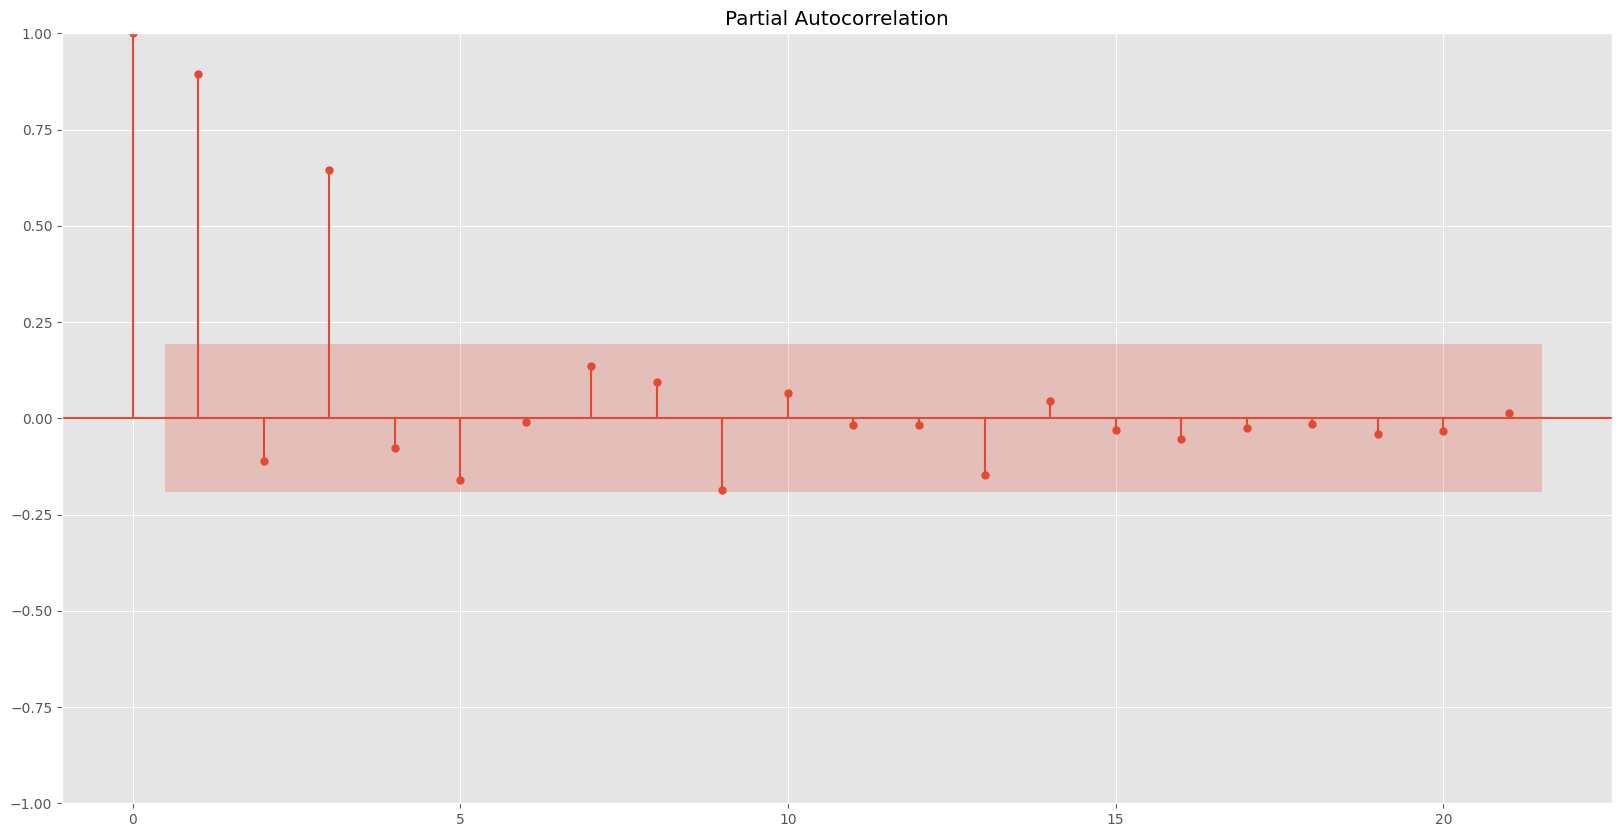

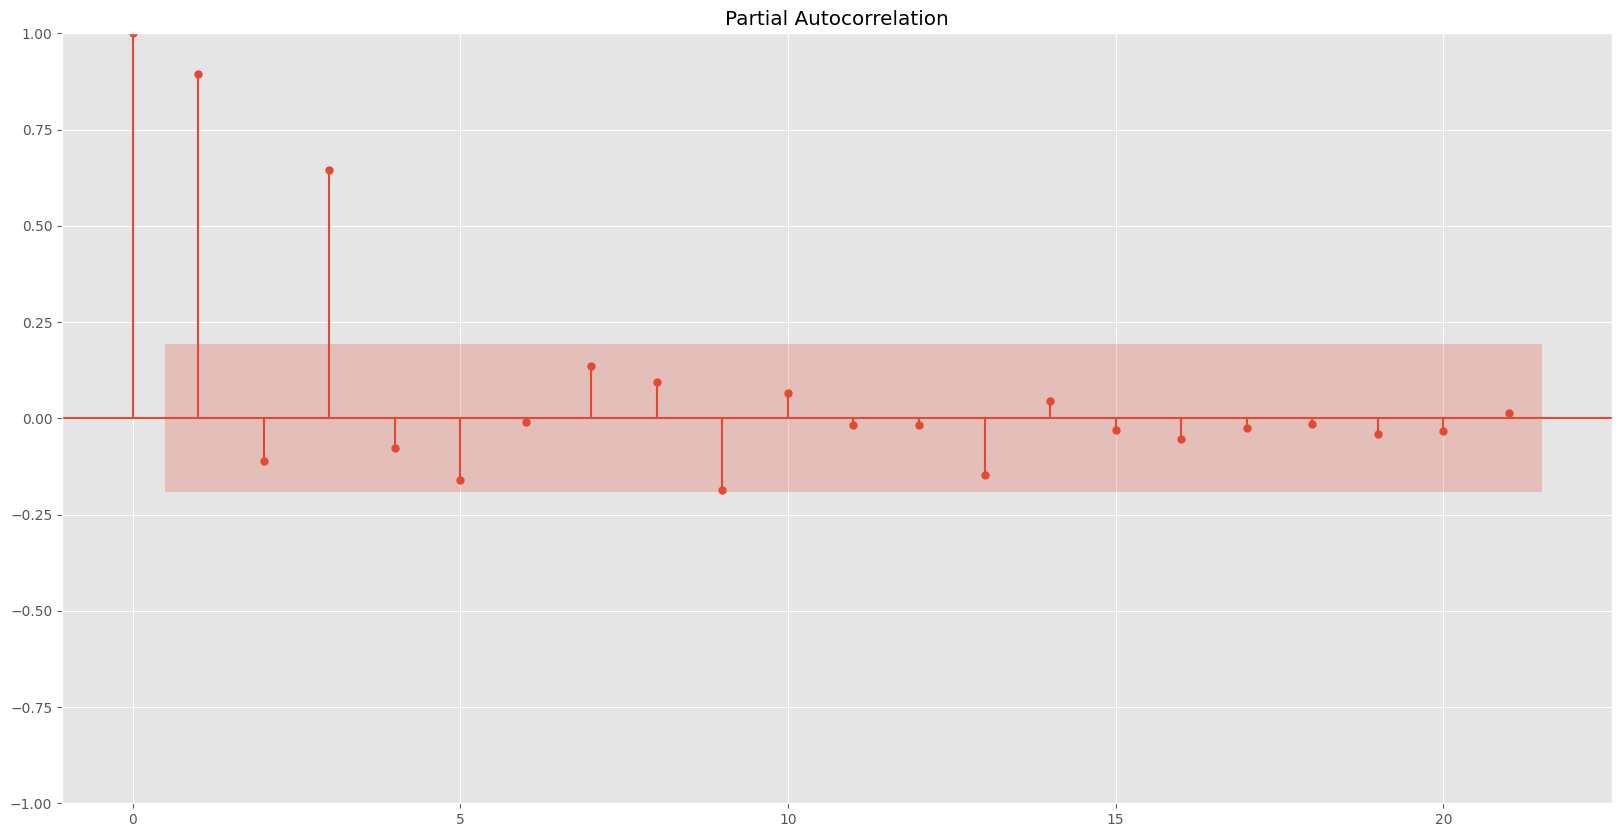

In [111]:
# 绘制原始数据的偏自相关图
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(data)

Two obvious patterns appear in the data, an overall increase in the number of passengers over time, and a 12 months seasonality with peaks corresponding to the northern emisphere summer period.

## ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three  integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q): 
<ul>
<li><strong>p</strong> is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</li>
<li><strong>d</strong> is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</li>
<li><strong>q</strong> is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.</li>
</ul>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (<strong>P, D, Q</strong>) follow the same definition but are applied to the seasonal component of the time series. The term <strong>s</strong> is the periodicity of the time series.

While in this case it is clear that s=12, how do we set the other parameters? 

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models, such as: 
http://people.duke.edu/~rnau/arimrule.htm.

Here we use grid search over all possible combinations of parameter values within a predefined range of values (heavily inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3). 

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

In [86]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 4)
SARIMAX: (0, 0, 1) x (0, 1, 0, 4)
SARIMAX: (0, 1, 0) x (0, 1, 1, 4)
SARIMAX: (0, 1, 0) x (1, 0, 0, 4)


We select a subset of the data series as training data, say the first 11 years. Our goal is to predict the last year of the series based on this input.

In [87]:
train_data = data['1995-01-01':'2015-12-01']
test_data = data['2016-01-01':'2020-12-01']

In [88]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [89]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 1944.9147565708568 for model SARIMAX(3, 1, 0)x(3, 1, 1, 4)


In [90]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],

                                enforce_invertibility=False)

results = mod.fit()

Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated. To do this, we can use the $plot\_diagnostics$ method.

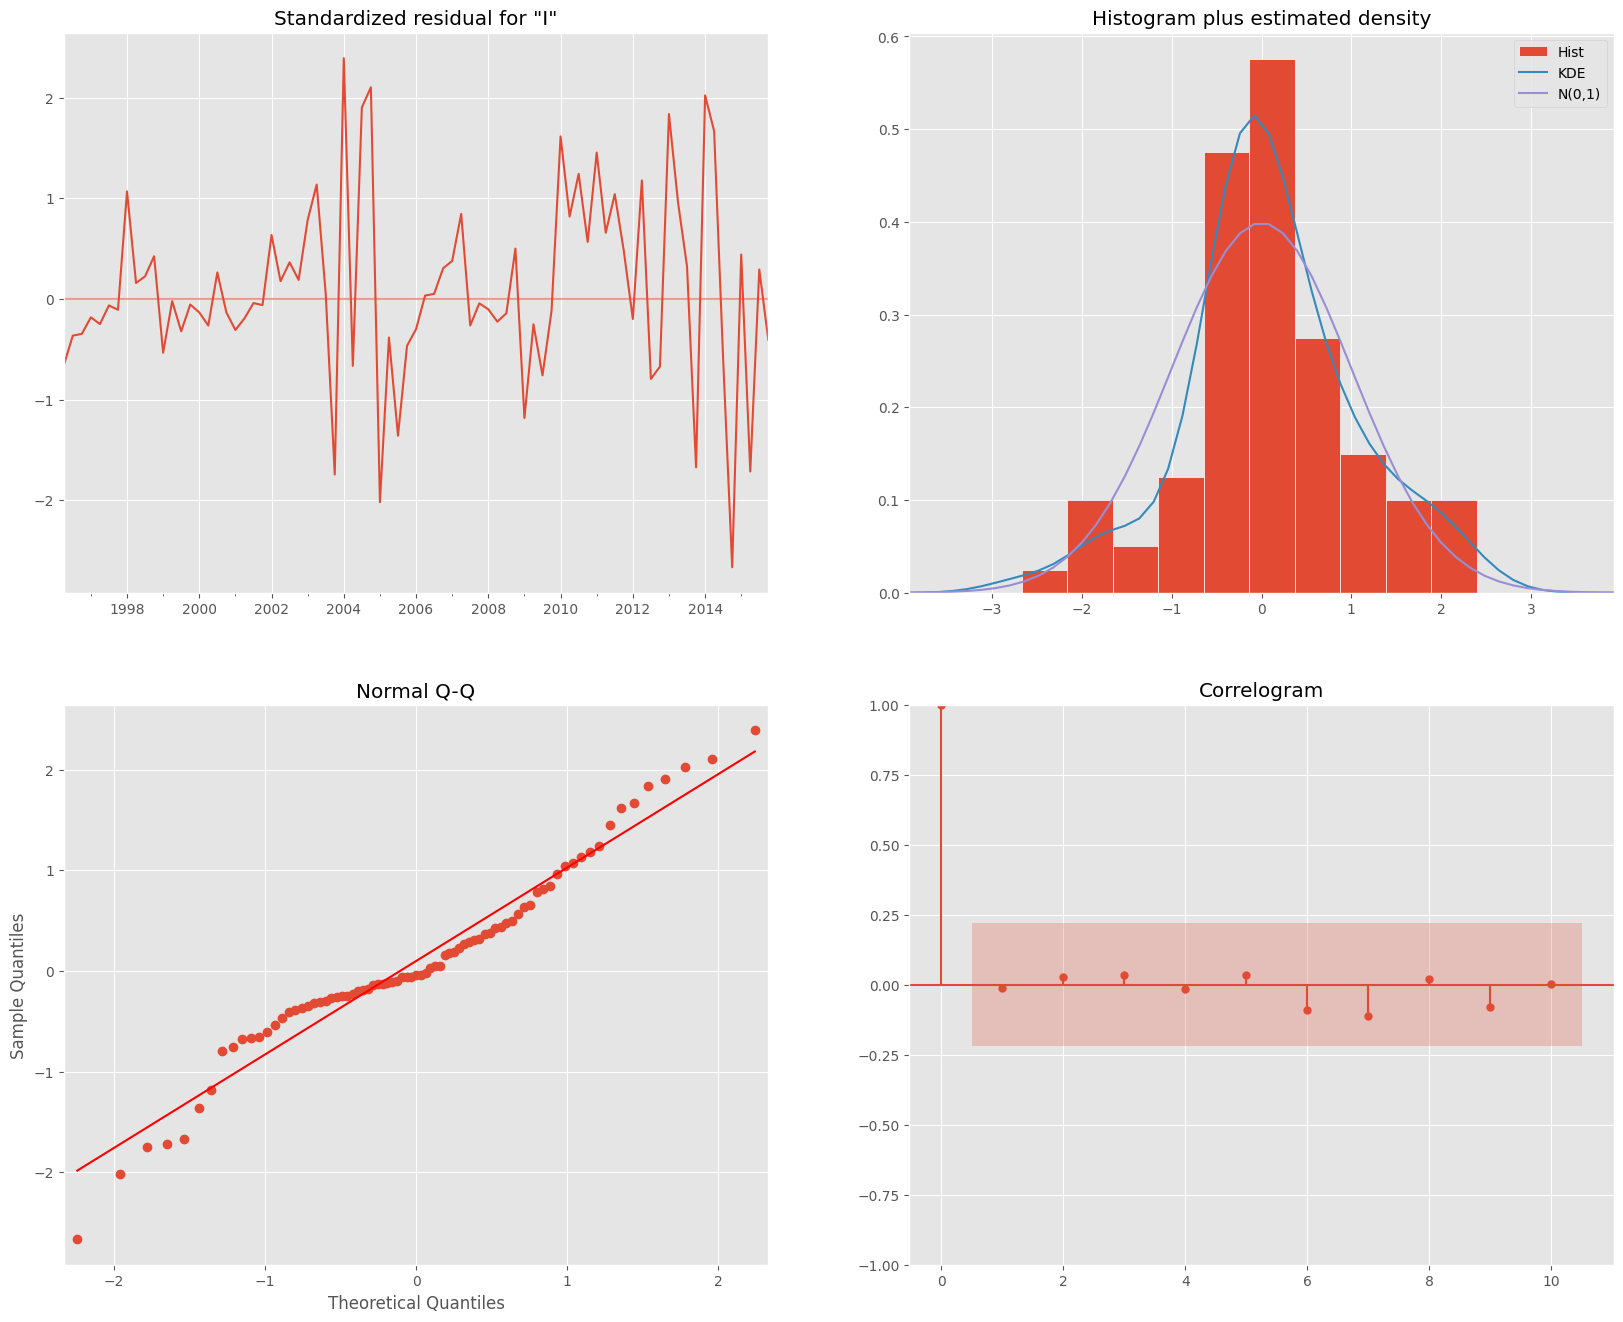

In [91]:
results.plot_diagnostics(figsize=(20, 16))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

## Results
Now let's create some predictions. We will use three methods:

1) In sample prediction with 1-step ahead forecasting of the last year (1959). In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the following one.

In [107]:
pred0 = results.get_prediction(start='2014-03-01', dynamic=False)
pred0_ci = pred0.conf_int()

2) In sample prediction with dynamic forecasting of the last year (1959). Again, the model is used to predict data that the model was built on.

In [108]:
pred1 = results.get_prediction(start='2014-03-01', dynamic=True)
pred1_ci = pred1.conf_int()

3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [97]:
pred2 = results.get_forecast('2030-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2020-01-01':'2020-12-01'])

2020-03-01    4.885344e+07
2020-06-01    5.502764e+07
2020-09-01    4.819134e+07
2020-12-01    3.967233e+07
Freq: QS-DEC, Name: predicted_mean, dtype: float64


Let's plot all this

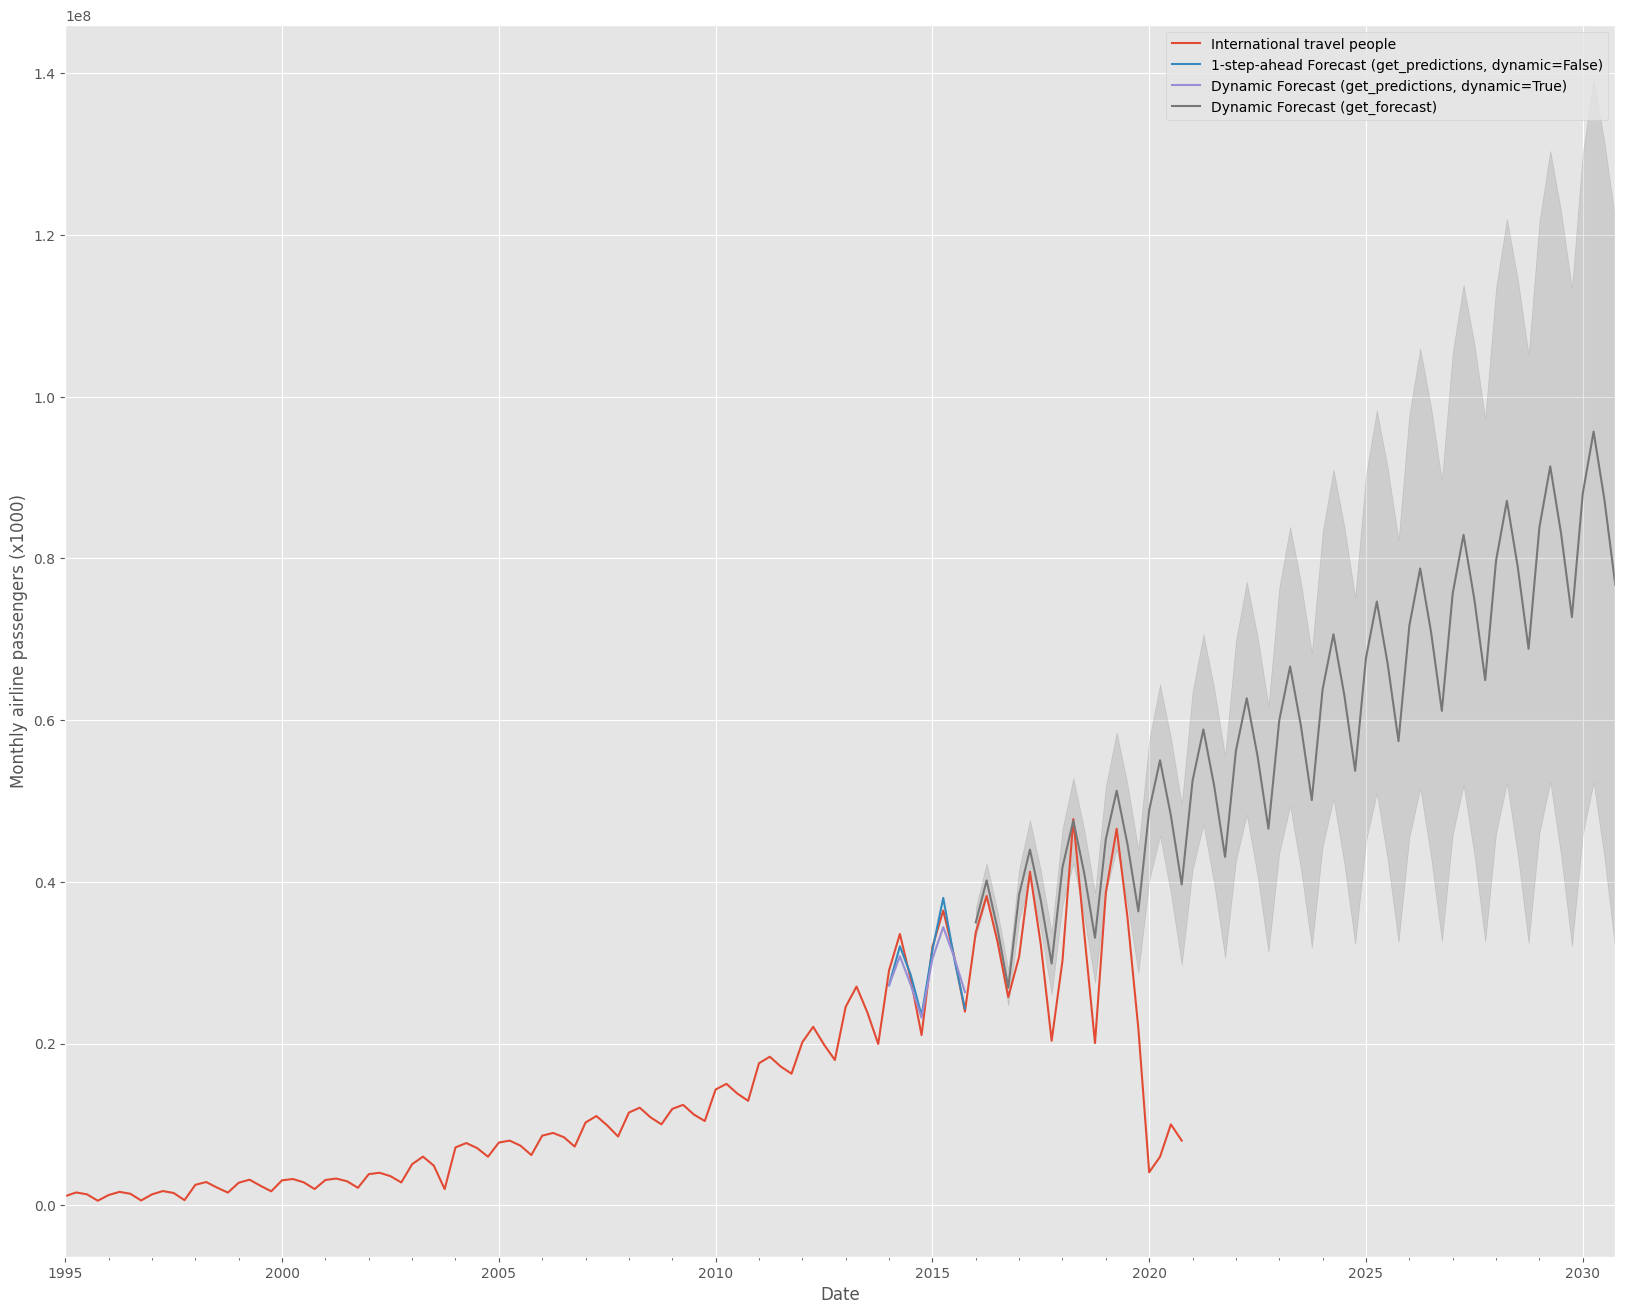

In [109]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

Looking at the figure, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample predinction. For such a simple time series, the ARIMA model is able to forecast the 1960 values accurately.

In order to quantify the accuracy of the prediction for 1960, we can compute metrics such as Mean Absolute Error, Mean Squared Error, or Root Mean Squared Error. These are all absolute metrics, are therefore scale-dependent. While they are useful, and widely used to compare different methods on a same dataset, here it would be more useful to express the error relatively to the magnitude of the time series we are trying to predict. One commonly-used percentage error measure is the Mean Absolute Percentage Error (MAPE). It has some drawbacks in special cases (notably, it can lead to division by zero) and improved measures have been proposed, see e.g. https://www.otexts.org/fpp/2/5 for a nice overview. However, for this example we'll stick with MAPE.

In [96]:
prediction = pred2.predicted_mean['2016-01-01':'2020-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 2020 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 2020 is 152.51%
